In [39]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from torchtext.legacy.data import Field, TabularDataset, BucketIterator
import matplotlib.pyplot as plt

# dataset folder
source_folder = "solo_classification_REMI_dataset_unbalanced"
# where it saves the weights
destination_folder = "solo_classification_transformer_REMI_weights_unaugmented"

In [40]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu" 
print(dev)
device = torch.device(dev)
print(device)

cuda:0
cuda:0


In [41]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize=None, lower=True, include_lengths=True, batch_first=True)
fields = [('labels', label_field), ('notes', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='val.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.notes),
                            device=device, sort=False, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.notes),
                            device=device, sort=False, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.notes),
                            device=device, sort=False, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=1)

In [42]:
ntokens = len(text_field.vocab)
emsize = 200
d_hid = 64
nlayers = 2 
nhead = 8
dropout = 0.6

In [43]:
for (labels, (notes, notes_len)), _ in (train_iter):
    print(notes)

tensor([[  4,   7,  30,  ...,  17,  62, 188],
        [  4,   7,  58,  ...,  50,   3,   1],
        [  4,   7,  58,  ...,  38, 171,   1],
        ...,
        [  4,   7, 186,  ...,   1,   1,   1],
        [  4,   7,  58,  ...,   1,   1,   1],
        [  4,   7,  58,  ...,   1,   1,   1]], device='cuda:0')
tensor([[ 4,  7, 30,  ..., 15, 38, 84],
        [ 4,  7, 58,  ...,  1,  1,  1],
        [ 4,  7, 30,  ...,  1,  1,  1],
        ...,
        [ 4,  7, 30,  ...,  1,  1,  1],
        [ 4,  7, 30,  ...,  1,  1,  1],
        [ 4,  7, 30,  ...,  1,  1,  1]], device='cuda:0')
tensor([[ 4,  7, 58,  ..., 12, 63, 46],
        [ 4,  7, 58,  ..., 43,  2,  1],
        [ 4,  7, 30,  ..., 66, 89,  1],
        ...,
        [ 4,  7, 30,  ...,  5,  1,  1],
        [ 4,  7, 30,  ...,  3,  1,  1],
        [ 4,  7, 30,  ...,  1,  1,  1]], device='cuda:0')
tensor([[ 4,  7, 58,  ..., 12, 52,  2],
        [ 4,  7, 58,  ...,  1,  1,  1],
        [ 4,  7, 58,  ...,  1,  1,  1],
        ...,
        [ 4,  7, 3

In [44]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [45]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, 2)
        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output.mean(dim=1)
        output = self.decoder(output)
        output = torch.sigmoid(output)
        return output
    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [46]:
# Save and Load Functions https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [34]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 10,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        total = 0
        total_correct = 0
        for (labels, (notes, notes_len)), _ in (train_loader):   
            labels = labels.to(device)
            notes = notes.to(device)
            notes_len = notes_len.cpu()
            output = model(notes.long())
            loss = criterion(output, labels.long())
            #loss = criterion(output.view(-1,1),labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            labels_max = labels.detach().cpu()
            output_max = np.argmax((output.detach().cpu()),axis=1)
            for i in range(len(labels_max)):
                total+=1
                if labels_max[i] ==  output_max[i]:
                    total_correct += 1
            accuracy = accuracy_score(labels_max, output_max)
            
            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                    for (labels, (notes, notes_len)), _ in (valid_loader):        
                        labels = labels.to(device)
                        notes = notes.to(device)
                        notes_len = notes_len.cpu()
                        output = model(notes.long())
                        loss = criterion(output, labels.long())
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
        print("Epoch Accuracy: {}".format(total_correct/total))
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = TransformerModel(ntokens,emsize,nhead,d_hid,nlayers,dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train(model=model, optimizer=optimizer, num_epochs=100)

Epoch [1/100], Step [173/34600], Train Loss: 0.6387, Valid Loss: 0.6465
Model saved to ==> solo_classification_transformer_REMI_weights/model.pt
Model saved to ==> solo_classification_transformer_REMI_weights/metrics.pt
Epoch [1/100], Step [346/34600], Train Loss: 0.6322, Valid Loss: 0.6168
Model saved to ==> solo_classification_transformer_REMI_weights/model.pt
Model saved to ==> solo_classification_transformer_REMI_weights/metrics.pt
Epoch Accuracy: 0.6664856056491038
Epoch [2/100], Step [519/34600], Train Loss: 0.6249, Valid Loss: 0.6223
Epoch [2/100], Step [692/34600], Train Loss: 0.6141, Valid Loss: 0.6272
Epoch Accuracy: 0.678164041281912
Epoch [3/100], Step [865/34600], Train Loss: 0.6031, Valid Loss: 0.6602
Epoch [3/100], Step [1038/34600], Train Loss: 0.5831, Valid Loss: 0.6391
Epoch Accuracy: 0.7010682600036212
Epoch [4/100], Step [1211/34600], Train Loss: 0.5808, Valid Loss: 0.6429
Epoch [4/100], Step [1384/34600], Train Loss: 0.5684, Valid Loss: 0.6392
Epoch Accuracy: 0.721

Epoch [43/100], Step [14878/34600], Train Loss: 0.5248, Valid Loss: 0.6197
Epoch Accuracy: 0.7855332246967228
Epoch [44/100], Step [15051/34600], Train Loss: 0.5269, Valid Loss: 0.6464
Epoch [44/100], Step [15224/34600], Train Loss: 0.5207, Valid Loss: 0.6222
Epoch Accuracy: 0.7819120043454644
Epoch [45/100], Step [15397/34600], Train Loss: 0.5221, Valid Loss: 0.6291
Epoch [45/100], Step [15570/34600], Train Loss: 0.5231, Valid Loss: 0.6267
Epoch Accuracy: 0.7857142857142857
Epoch [46/100], Step [15743/34600], Train Loss: 0.5164, Valid Loss: 0.6353
Epoch [46/100], Step [15916/34600], Train Loss: 0.5211, Valid Loss: 0.6252
Epoch Accuracy: 0.7887017925040739
Epoch [47/100], Step [16089/34600], Train Loss: 0.5220, Valid Loss: 0.6356
Epoch [47/100], Step [16262/34600], Train Loss: 0.5220, Valid Loss: 0.6391
Epoch Accuracy: 0.7866195908021003
Epoch [48/100], Step [16435/34600], Train Loss: 0.5252, Valid Loss: 0.6365
Epoch [48/100], Step [16608/34600], Train Loss: 0.5189, Valid Loss: 0.6314


Epoch [86/100], Step [29756/34600], Train Loss: 0.5011, Valid Loss: 0.6106
Epoch Accuracy: 0.8091616874886837
Epoch [87/100], Step [29929/34600], Train Loss: 0.4871, Valid Loss: 0.6268
Epoch [87/100], Step [30102/34600], Train Loss: 0.5071, Valid Loss: 0.6197
Epoch Accuracy: 0.8126923773311606
Epoch [88/100], Step [30275/34600], Train Loss: 0.4991, Valid Loss: 0.6288
Epoch [88/100], Step [30448/34600], Train Loss: 0.4987, Valid Loss: 0.6103
Epoch Accuracy: 0.8089806264711208
Epoch [89/100], Step [30621/34600], Train Loss: 0.4890, Valid Loss: 0.6130
Epoch [89/100], Step [30794/34600], Train Loss: 0.5064, Valid Loss: 0.6082
Epoch Accuracy: 0.810610175629187
Epoch [90/100], Step [30967/34600], Train Loss: 0.4896, Valid Loss: 0.6114
Epoch [90/100], Step [31140/34600], Train Loss: 0.5035, Valid Loss: 0.6084
Epoch Accuracy: 0.8116060112257831
Epoch [91/100], Step [31313/34600], Train Loss: 0.4949, Valid Loss: 0.6125
Epoch [91/100], Step [31486/34600], Train Loss: 0.4953, Valid Loss: 0.6066
E

In [35]:
# torch.backends.cudnn.enabled = False

Model loaded from <== solo_classification_transformer_REMI_weights_unaugmented/metrics.pt


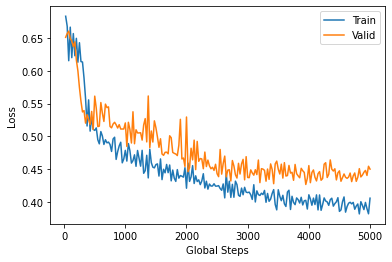

In [47]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()

plt.savefig("Transformer.png")
plt.show() 

In [48]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

Model loaded from <== solo_classification_transformer_REMI_weights_unaugmented/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.7750    0.8304    0.8017       112
           0     0.9120    0.8795    0.8955       224

    accuracy                         0.8631       336
   macro avg     0.8435    0.8549    0.8486       336
weighted avg     0.8664    0.8631    0.8642       336



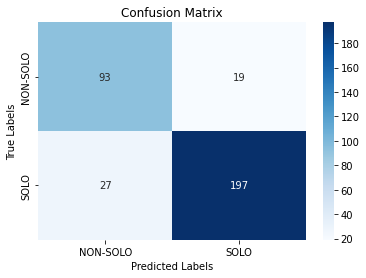

In [49]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (notes, notes_len)), _ in test_loader:           
            labels = labels.to(device)
            notes = notes.to(device)
            notes_len = notes_len.cpu()
            output = model(notes.long())

            output = np.argmax(output.cpu().detach(), axis=1)
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['NON-SOLO', 'SOLO'])
    ax.yaxis.set_ticklabels(['NON-SOLO', 'SOLO'])
    
    
best_model = TransformerModel(ntokens,emsize,nhead,d_hid,nlayers,dropout).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

In [14]:
from torchviz import make_dot
import hiddenlayer as hl

ModuleNotFoundError: No module named 'torchviz'

In [ ]:
next(iter(test_iter)).notes

In [ ]:
def print_architecture(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    for (labels, (notes, notes_len)), _ in test_loader:           
        labels = labels.to(device)
        notes = notes.to(device)
        notes_len = notes_len.cpu()
        output = model(notes.long(), notes_len.long())
        
        
        transforms = [# hl.transforms.Prune('Constant'),
                      #hl.transforms.FoldDuplicates()
                     ] # Removes Constant nodes from graph.

        graph = hl.build_graph(model, (notes,notes_len), transforms=transforms)
        graph.theme = hl.graph.THEMES['blue'].copy()
        print(graph)
        graph.save('rnn_hiddenlayer', format='png')

        #output = (output > threshold).int()
        #y_pred.extend(output.tolist())
        #y_true.extend(labels.tolist())
        #print(dict(model.named_parameters()))
        #make_dot(output,params=dict(model.named_parameters())).render()
        break

    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
print_architecture(best_model, test_iter)

In [ ]:
# print(best_model)